In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

# basic libraries
import os
import numpy as np
import pandas as pd
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import re
import string
from collections import Counter
import time

#visulaization modules
import matplotlib.pyplot as plt
import missingno as msno
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode


#Common model helpers
from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder,
                                   OneHotEncoder,)
from sklearn.compose import ColumnTransformer


from sklearn.metrics import (accuracy_score,
                             auc,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score,
                             confusion_matrix,
                             classification_report,
                             plot_confusion_matrix,
                             r2_score,
                             get_scorer_names,
                             roc_curve)

from sklearn.model_selection import (GridSearchCV,
                                     RandomizedSearchCV,
                                     StratifiedKFold,
                                     cross_val_score,
                                     train_test_split)


# dimensionality reduction
from sklearn.decomposition import PCA
#from umap import UMAP
import pylab as pl

# imbalance dataset handling
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from imblearn.datasets import make_imbalance
from imblearn.under_sampling import (RandomUnderSampler,
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     EditedNearestNeighbours,
                                     NearMiss)


from imblearn.over_sampling import (SMOTE,
                                    SMOTENC,
                                    ADASYN,
                                    RandomOverSampler)




# model algorithams
from sklearn.ensemble import (RandomForestClassifier,
                              AdaBoostClassifier,
                              GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline

%matplotlib inline

In [2]:
data = pd.read_csv('../data/full.csv')
data.drop(['id', 'index'], inplace=True, axis=1)

In [3]:
target = data['stroke']
cat_features = ['work_type']
num_features = ['age','avg_glucose_level','bmi']
other_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']

In [4]:
standard = StandardScaler()
encode = OneHotEncoder()
feat_en = encode.fit_transform(data[cat_features]).toarray()
feat_st = standard.fit_transform(data[num_features])
features = np.concatenate((feat_en, feat_st, data[other_features]), axis=1)

features_train,features_test,target_train,target_test=train_test_split(features, target ,test_size=0.2,stratify=target,random_state=100)

In [5]:
re_samplers = [SMOTE(), ADASYN(), RandomOverSampler(), RandomUnderSampler(), ClusterCentroids(), TomekLinks(), NeighbourhoodCleaningRule(), EditedNearestNeighbours(),NearMiss()]
models_names = ['DecisionTreeClassifier', 'RandomForestClassifier', 'KNeighborsClassifier', 'GaussianNB']

In [6]:
resampled_data = [['OriginalData', features_train, target_train]]

for el in re_samplers:
    x_train, y_train = el.fit_resample(features_train, target_train)
    resampled_data.append([str(el), x_train, y_train])


In [7]:
def resampling():
    fitting_results = pd.DataFrame()

    for line in resampled_data:
        models = [[DecisionTreeClassifier(), 'DecisionTreeClassifier'],
                  [RandomForestClassifier(), 'RandomForestClassifier'],
                  [KNeighborsClassifier(), 'KNeighborsClassifier'],
                  [GaussianNB(), 'GaussianNB']]
        fitting_results = pd.concat([fitting_results, fitting(line[1], line[2], line[0], models)], axis=0)

    return fitting_results

def fitting(x, y, resemp, models):
    p = pd.DataFrame()

    for model in models:
        model[0].fit(x, y)
        prediction = model[0].predict(features_test)

        dict = {
        'resempler':[resemp],
        'classifier_name':[model[1]],
        'f1_score': [f1_score(target_test, prediction)],
        'accuracy_score':[accuracy_score(target_test, prediction)],
        'precision_score': [precision_score(target_test, prediction)],
        'recall_score':[recall_score(target_test, prediction)],
        'roc_auc_score':[roc_auc_score(target_test, prediction)],
        'confusion_matrix':[confusion_matrix(target_test,prediction)]
        }

        p = pd.concat([pd.DataFrame(dict), p], axis=0)
    return p

In [10]:
res = resampling()
res.sort_values(['roc_auc_score'], ascending=False)

,resempler,classifier_name,f1_score,accuracy_score,precision_score,recall_score,roc_auc_score,confusion_matrix
0,RandomUnderSampler(),RandomForestClassifier,0.182320,0.698574,0.103125,0.785714,0.740198,"[[653, 287], [9, 33]]"
0,ClusterCentroids(),RandomForestClassifier,0.149533,0.536660,0.081136,0.952381,0.735233,"[[487, 453], [2, 40]]"
0,RandomUnderSampler(),GaussianNB,0.149451,0.605906,0.082324,0.809524,0.703166,"[[561, 379], [8, 34]]"
0,RandomUnderSampler(),KNeighborsClassifier,0.159574,0.678208,0.089820,0.714286,0.695441,"[[636, 304], [12, 30]]"
0,RandomUnderSampler(),DecisionTreeClassifier,0.151134,0.656823,0.084507,0.714286,0.684271,"[[615, 325], [12, 30]]"
0,EditedNearestNeighbours(),GaussianNB,0.116667,0.352342,0.061947,1.000000,0.661702,"[[304, 636], [0, 42]]"
0,NeighbourhoodCleaningRule(),GaussianNB,0.116667,0.352342,0.061947,1.000000,0.661702,"[[304, 636], [0, 42]]"
0,TomekLinks(),GaussianNB,0.115862,0.347251,0.061493,1.000000,0.659043,"[[299, 641], [0, 42]]"
0,OriginalData,GaussianNB,0.115702,0.346232,0.061404,1.000000,0.658511,"[[298, 642], [0, 42]]"
0,ADASYN(),GaussianNB,0.113360,0.330957,0.060086,1.000000,0.650532,"[[283, 657], [0, 42]]"


In [9]:
def roc(model, resempler, name):
    x_train, y_train = resempler.fit_resample(features_train, target_train)
    model.fit(x_train, y_train)
    y_prob = model.predict_proba(features_test)[:,1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(target_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate,true_positive_rate, label = f'{name} AUC = %0.3f' % roc_auc)

    #return false_positive_rate, true_positive_rate, roc_auc

Text(0.5, 0, 'False Positive Rate')

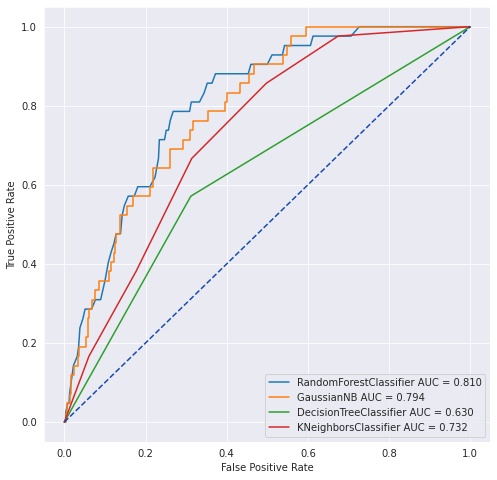

In [14]:
plt.figure(figsize = (8, 8))

DCTclassifier = DecisionTreeClassifier(max_depth=3, random_state=2022)
#roc(XGBMclassifier, SMOTE(), 'XGBMclassifier')

roc(RandomForestClassifier(), RandomUnderSampler(), 'RandomForestClassifier')
roc(GaussianNB(), RandomUnderSampler(), 'GaussianNB')
roc(DecisionTreeClassifier(), RandomUnderSampler(), 'DecisionTreeClassifier')
roc(KNeighborsClassifier(), RandomUnderSampler(), 'KNeighborsClassifier')

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [19]:
rand_forest_params = {'bootstrap': [True, False], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
gaus_params = {
    'var_smoothing': [0.00000001, 0.000000001, 0.00000001]
}

In [21]:
best_models = [[RandomForestClassifier(), rand_forest_params],
               [GaussianNB(), gaus_params]]


X_resample, y_resample = RandomUnderSampler().fit_resample(features_train, target_train)
searches =[]

for i in range(2):
    
    model = best_models[i][0]

    rand = RandomizedSearchCV(estimator=model, param_distributions=best_models[i][1], scoring = 'roc_auc',cv = 10)
    rand.fit(X_resample, y_resample)
    best_accuracy = rand.best_score_
    best_param = rand.best_params_
    searches.append(rand)
    print(' {}: \n Best Accuracy: {:.2f} %'.format(model,best_accuracy*100))
    print('')
    print('-'*25)
    print('')


 RandomForestClassifier(): 
 Best Accuracy: 86.78 %

-------------------------

 GaussianNB(): 
 Best Accuracy: 83.77 %

-------------------------



In [23]:
def roc2(model, name):
    y_prob = model.predict_proba(features_test)[:,1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(target_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate,true_positive_rate, label = f'{name} AUC = %0.3f' % roc_auc)

    #return false_positive_rate, true_positive_rate, roc_auc

Text(0.5, 0, 'False Positive Rate')

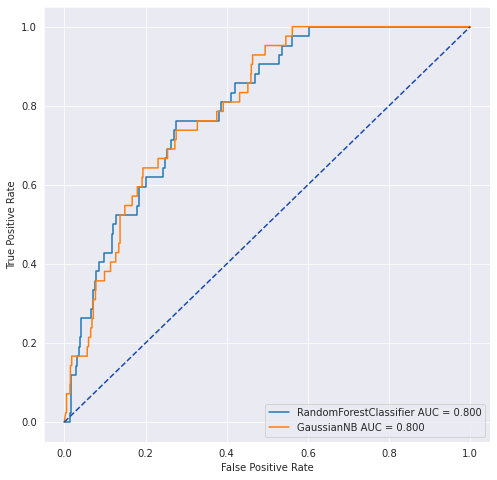

In [25]:
plt.figure(figsize = (8, 8))

DCTclassifier = DecisionTreeClassifier(max_depth=3, random_state=2022)
#roc(XGBMclassifier, SMOTE(), 'XGBMclassifier')


roc2(searches[0], 'RandomForestClassifier')
roc2(searches[1], 'GaussianNB')

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [26]:
prediction = searches[0].predict(features_test)

dict = {
        'f1_score': [f1_score(target_test, prediction)],
        'accuracy_score':[accuracy_score(target_test, prediction)],
        'precision_score': [precision_score(target_test, prediction)],
        'recall_score':[recall_score(target_test, prediction)],
        'roc_auc_score':[roc_auc_score(target_test, prediction)],
        'confusion_matrix':[confusion_matrix(target_test,prediction)]
        }
dict

{'f1_score': [0.1792717086834734],
 'accuracy_score': [0.7016293279022403],
 'precision_score': [0.10158730158730159],
 'recall_score': [0.7619047619047619],
 'roc_auc_score': [0.7304204660587639],
 'confusion_matrix': [array([[657, 283],
         [ 10,  32]])]}